## Load dataset

In [68]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('/Users/holly/Downloads/table1.xlsx')

# Display the first few rows of the DataFrame
print(df.head)

<bound method NDFrame.head of      102.717308   98.516403    104.984789   109.618074   108.831948  \
0     11.358988    12.646215    13.435356    12.506009    12.793869   
1     24.937739    27.031606    30.257542    34.484241    36.772653   
2     36.238491    35.147374    37.246511    40.904539    39.181082   
3    294.672829   306.128867   313.001675   329.536275   304.727911   
4     43.057661    43.628581    47.509428    51.112474    50.519445   
5     47.839723    45.901611    47.222932    48.585809    45.433967   
6     16.051567    15.907361    15.991638    17.221577    16.636428   
7     13.642245    11.877348    11.306110    11.850583     9.849625   
8    104.403707   111.555148   121.728053   132.294566   124.346429   
9     73.602335    79.643584    86.841657    93.198139    91.777575   
10    13.928826    15.053557    15.492609    15.947073    15.099352   
11    10.265344    11.083788    11.660743    11.974538    12.092394   
12   247.328162   243.870883   253.433879   257

## Models 

### New Method

In [69]:
import pandas as pd

# Load the data (ensure the "Total of states" row is excluded)
df = pd.read_excel("table1.1.xlsx")
df = df[df["State"] != "Total of states"]  # Remove the total row

# Melt the data into long format
df_long = pd.melt(df, id_vars=["State"], var_name="Year", value_name="Consumption")
df_long["Year"] = df_long["Year"].astype(int)
df_long["Consumption"] = df_long["Consumption"].astype(float)

In [70]:
df_long = df_long.sort_values(["State", "Year"])
df_long["Consumption"] = df_long.groupby("State")["Consumption"].transform(
    lambda x: x.interpolate(method="linear")  # Linear interpolation for gaps
)

In [71]:
# Lagged features and rolling averages
df_long["Lag_1"] = df_long.groupby("State")["Consumption"].shift(1)
df_long["Rolling_Mean_3"] = df_long.groupby("State")["Consumption"].transform(
    lambda x: x.rolling(3).mean()
)

In [72]:
from lightgbm import LGBMRegressor
import numpy as np

# Split data for a single state (e.g., Alabama)
state_data = df_long[df_long["State"] == "Alabama"].dropna()
X = state_data[["Year", "Lag_1", "Rolling_Mean_3"]]
y = state_data["Consumption"]

# Train-test split (2020-2022 as test data)
train = X[X["Year"] < 2020]
test = X[X["Year"] >= 2020]

# Train the model
model = LGBMRegressor()
model.fit(train, y[train.index])

# Predict 2023-2025
future_years = pd.DataFrame({
    "Year": [2023, 2024, 2025],
    "Lag_1": [y.iloc[-1], np.nan, np.nan],  # Propagate the last known value
    "Rolling_Mean_3": [y.rolling(3).mean().iloc[-1], np.nan, np.nan]
})
future_years.fillna(method="ffill", inplace=True)  # Forward fill missing lags
predictions = model.predict(future_years)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 3
[LightGBM] [Info] Start training from score 119.175227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/var/folders/fd/tf9m44dj0tvfhkp_rp0b4p040000gn/T/ipykernel_43829/2330883944.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_years.fillna(method="ffill", inplace=True)  # Forward fill missing lags


In [73]:
from prophet import Prophet

# Format data for Prophet
prophet_df = state_data.rename(columns={"Year": "ds", "Consumption": "y"})

# Train and forecast
model = Prophet(yearly_seasonality=True)
model.fit(prophet_df)
future = model.make_future_dataframe(periods=3, freq="Y")
forecast = model.predict(future)

10:01:51 - cmdstanpy - INFO - Chain [1] start processing
10:01:51 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [74]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import torch

# Prophet model predictions
prophet_df = state_data.rename(columns={"Year": "ds", "Consumption": "y"})
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=3, freq="Y")
forecast = prophet_model.predict(future)

# Extract actual and predicted values for Prophet
actual_prophet = prophet_df['y'].values
predicted_prophet = forecast['yhat'][:len(actual_prophet)].values

# Calculate MAE for Prophet model
mae_prophet = mean_absolute_error(actual_prophet, predicted_prophet)


10:01:51 - cmdstanpy - INFO - Chain [1] start processing
10:01:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [75]:
print(mae_prophet)

22.781789834285973


## Neural Network

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# Assuming X and y are your features and target variables
X = np.random.rand(1000, 10)  # Example data
y = np.random.rand(1000, 1)   # Example target

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader objects
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=50, shuffle=False)


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(48, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
learning_rate = 0.005
num_epochs = 1000
batch_size = 45

# Model, loss function, optimizer
torch_model = Net(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(torch_model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    torch_model.train()
    for X_batch, y_batch in train_loader:
        outputs = torch_model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    torch_model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch in val_loader:
            outputs = torch_model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
        val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

# Evaluate the model
torch_model.eval()
with torch.no_grad():
    y_pred_torch = torch_model(X_test).numpy()

# Calculate MAE for PyTorch model
mae_torch = mean_absolute_error(y_test, y_pred_torch)
print(f"MAE for PyTorch model: {mae_torch:.2f}")

Epoch [1/1000], Validation Loss: 0.1273
Epoch [2/1000], Validation Loss: 0.1168
Epoch [3/1000], Validation Loss: 0.0947
Epoch [4/1000], Validation Loss: 0.0969
Epoch [5/1000], Validation Loss: 0.0940
Epoch [6/1000], Validation Loss: 0.0946
Epoch [7/1000], Validation Loss: 0.0953
Epoch [8/1000], Validation Loss: 0.0977
Epoch [9/1000], Validation Loss: 0.0992
Epoch [10/1000], Validation Loss: 0.0950
Epoch [11/1000], Validation Loss: 0.0980
Epoch [12/1000], Validation Loss: 0.0950
Epoch [13/1000], Validation Loss: 0.1001
Epoch [14/1000], Validation Loss: 0.0951
Epoch [15/1000], Validation Loss: 0.0968
Epoch [16/1000], Validation Loss: 0.0953
Epoch [17/1000], Validation Loss: 0.0947
Epoch [18/1000], Validation Loss: 0.0967
Epoch [19/1000], Validation Loss: 0.1013
Epoch [20/1000], Validation Loss: 0.0963
Epoch [21/1000], Validation Loss: 0.0999
Epoch [22/1000], Validation Loss: 0.1029
Epoch [23/1000], Validation Loss: 0.0994
Epoch [24/1000], Validation Loss: 0.0947
Epoch [25/1000], Validati

In [77]:
# Show the predictions
print(y_pred_torch)
print(f'Mean Absolute Error for Prophet model: {mae_prophet:.2f}')


[[ 0.54186904]
 [ 0.38561907]
 [ 0.4533626 ]
 [ 0.33081862]
 [ 0.8230474 ]
 [ 1.1218665 ]
 [ 0.39621988]
 [ 0.55348563]
 [ 0.3567504 ]
 [ 0.60274065]
 [ 1.1312813 ]
 [ 0.8057716 ]
 [ 0.77737665]
 [ 0.4324433 ]
 [ 0.20957544]
 [ 0.31419876]
 [ 0.33866826]
 [ 0.5832839 ]
 [-0.51187766]
 [ 0.43838802]
 [ 0.57598555]
 [ 0.621156  ]
 [ 0.29289857]
 [ 0.5312282 ]
 [ 0.5765953 ]
 [ 0.8999014 ]
 [ 0.3721318 ]
 [ 0.40306166]
 [ 0.51283264]
 [ 0.31862417]
 [ 0.28266552]
 [ 0.41996744]
 [ 0.96593904]
 [ 0.29039755]
 [ 0.66307855]
 [ 0.80574346]
 [ 0.6431296 ]
 [ 0.6438683 ]
 [ 0.20203438]
 [ 0.39876345]
 [ 0.7323451 ]
 [ 0.1937227 ]
 [ 0.02987686]
 [ 0.32006922]
 [ 0.58059835]
 [ 0.37123087]
 [ 0.03884718]
 [ 0.05634573]
 [ 1.1934026 ]
 [ 0.28348944]
 [ 0.71863747]
 [ 0.89005685]
 [ 0.38934144]
 [-0.0745343 ]
 [ 0.09362194]
 [ 0.57452154]
 [ 0.23556736]
 [-0.32454   ]
 [ 1.102516  ]
 [ 0.33841768]
 [ 0.37305894]
 [ 0.44676176]
 [ 0.26726803]
 [ 0.45192233]
 [ 0.4355161 ]
 [ 0.66459596]
 [ 0.57441

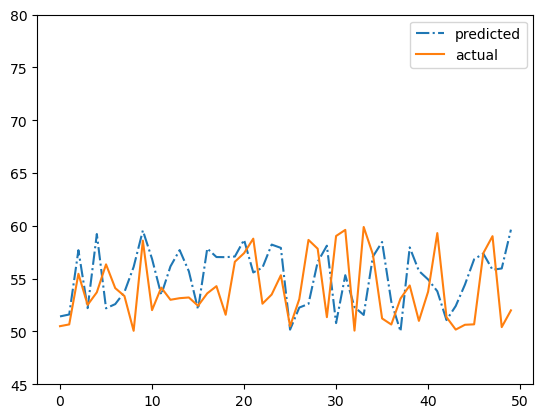

In [80]:
t = np.zeros(len(pred[2]))
for i in range(len(pred[2])):
    t[i] = i
plt.ylim(45, 80)
plt.plot(t, pred[0], label = "predicted", linestyle="-.")
plt.plot(t, actual[0], label = "actual", linestyle="-")
plt.legend()
plt.show()


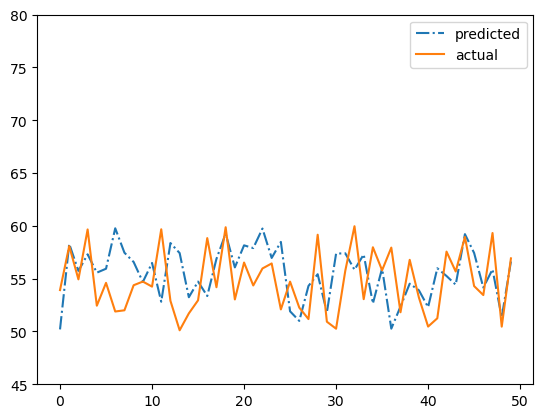

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for pred and actual
# Replace these with your actual data
pred = [np.random.rand(50) * 10 + 50, np.random.rand(50) * 10 + 50, np.random.rand(50) * 10 + 50]
actual = [np.random.rand(50) * 10 + 50, np.random.rand(50) * 10 + 50, np.random.rand(50) * 10 + 50]

# Generate time indices
t = np.arange(len(pred[0]))

# Plotting
plt.ylim(45, 80)
plt.plot(t, pred[0], label="predicted", linestyle="-.")
plt.plot(t, actual[0], label="actual", linestyle="-")
plt.legend()
plt.show()